In [1]:
import numpy as np

import matplotlib.pyplot as plt
import os
path = '../Projects/walker/'

In [2]:
os.path.exists('../Projects/walker/BipedalWalkerHardcore-v3_log.txt')

True

In [3]:
f = open("BipedalWalkerHardcore-v3log.txt",'r')
#print(f.readline())
#f.close()

FileNotFoundError: [Errno 2] No such file or directory: 'BipedalWalkerHardcore-v3log.txt'

In [4]:
f = open('../Projects/walker/BipedalWalkerHardcore-v3_log.txt','r')

rewards = []
for line in f.readlines():
    reward = float(line.split(',')[1].split("\n")[0])
    #break
    rewards.append(reward)
f.close()

def movingaverage(interval, window_size):
    window= np.ones(int(window_size))/float(window_size)
    return np.convolve(interval, window, 'same')


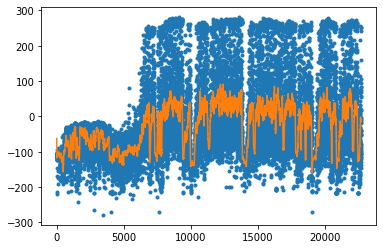

In [6]:
plt.plot(rewards,'.')
plt.plot(movingaverage(rewards,50))


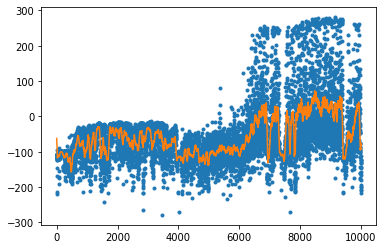

In [7]:
plt.plot(rewards[:10000],'.')
plt.plot(movingaverage(rewards[:10000],50))


# Load in policy for testing 

In [8]:
"""
Implementation of TD3 Algorithm on Open AI gym environment BipedalWalkerHardcore v3


"""

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import gym

from PIL import Image


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")



class ReplayBuffer:
    def __init__(self, max_size=5e5):
        self.buffer = []
        self.max_size = int(max_size)
        self.size = 0
    
    def add(self, transition):
        self.size +=1
        # transiton is tuple of (state, action, reward, next_state, done)
        self.buffer.append(transition)
    
    def sample(self, batch_size):
        # delete 1/5th of the buffer when full
        if self.size > self.max_size:
            del self.buffer[0:int(self.size/5)]
            self.size = len(self.buffer)
        
        indexes = np.random.randint(0, len(self.buffer), size=batch_size)
        state, action, reward, next_state, done = [], [], [], [], []
        
        for i in indexes:
            s, a, r, s_, d = self.buffer[i]
            state.append(np.array(s, copy=False))
            action.append(np.array(a, copy=False))
            reward.append(np.array(r, copy=False))
            next_state.append(np.array(s_, copy=False))
            done.append(np.array(d, copy=False))
        
        return np.array(state), np.array(action), np.array(reward), np.array(next_state), np.array(done)
    




class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, max_action):
        super(Actor, self).__init__()
        
        self.l1 = nn.Linear(state_dim, 400)
        self.l2 = nn.Linear(400, 300)
        self.l3 = nn.Linear(300, action_dim)
        
        self.max_action = max_action
        
    def forward(self, state):
        """
        Pass the state through mlp, and emit a value between -1 and 1, scaled by max action size. 
        
        Returns the action to take (along each dim of action dim)
        """
        a = F.relu(self.l1(state))
        a = F.relu(self.l2(a))
        a = torch.tanh(self.l3(a)) * self.max_action
        return a
        
class Critic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Critic, self).__init__()
        
        self.l1 = nn.Linear(state_dim + action_dim, 400)
        self.l2 = nn.Linear(400, 300)
        self.l3 = nn.Linear(300, 1)
        
    def forward(self, state, action):
        """
        Returns a Q(!) value for the network, given a state action input. The input is concatted and passed through an MLP
        of roughly the same size as before, but different input dim to account for the action(s) taken. 
        """
        state_action = torch.cat([state, action], 1)
        
        q = F.relu(self.l1(state_action))
        q = F.relu(self.l2(q))
        q = self.l3(q)
        return q
    
class TD3:
    def __init__(self, lr, state_dim, action_dim, max_action):
        
        self.actor = Actor(state_dim, action_dim, max_action).to(device)
        self.actor_target = Actor(state_dim, action_dim, max_action).to(device)
        self.actor_target.load_state_dict(self.actor.state_dict())
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=lr)
        
        self.critic_1 = Critic(state_dim, action_dim).to(device)
        self.critic_1_target = Critic(state_dim, action_dim).to(device)
        self.critic_1_target.load_state_dict(self.critic_1.state_dict())
        self.critic_1_optimizer = optim.Adam(self.critic_1.parameters(), lr=lr)
        
        self.critic_2 = Critic(state_dim, action_dim).to(device)
        self.critic_2_target = Critic(state_dim, action_dim).to(device)
        self.critic_2_target.load_state_dict(self.critic_2.state_dict())
        self.critic_2_optimizer = optim.Adam(self.critic_2.parameters(), lr=lr)
        
        self.max_action = max_action
    
    def select_action(self, state):
        """
        Pass the state (after casted to right type) through the actor network 
        """
        state = torch.FloatTensor(state.reshape(1, -1)).to(device)
        return self.actor(state).cpu().data.numpy().flatten()
    
    def update(self, replay_buffer, n_iter, batch_size, gamma, polyak, policy_noise, noise_clip, policy_delay):
        """
        Update the actor and critic networks. The difference here between TD3 and DDPG is that there
        
        are now two critic newtworks, both of which compute the Q value, and we designate our
        target Q value as the smaller between the two critic network predictions. 
        """
        for i in range(n_iter):
            # Sample a batch of transitions from replay buffer:
            
            # providing us with our s a r s' done tuple. 
            state, action_, reward, next_state, done = replay_buffer.sample(batch_size)
            state = torch.FloatTensor(state).to(device)
            action = torch.FloatTensor(action_).to(device)
            reward = torch.FloatTensor(reward).reshape((batch_size,1)).to(device)
            next_state = torch.FloatTensor(next_state).to(device)
            done = torch.FloatTensor(done).reshape((batch_size,1)).to(device)
            
            # Select next action according to target policy:
            
            # the next action we take is chosen by pasing our next state vector into the target policy network
            # the target policy network, a polyak averaged slowly updating version of the current policy network. 
            
            noise = torch.FloatTensor(action_).data.normal_(0, policy_noise).to(device) # we still use noise for our target? 
            noise = noise.clamp(-noise_clip, noise_clip) # this val pre-defined as at most .5
            next_action = (self.actor_target(next_state) + noise) # actor predicts next action choice, and we sprinkle in a little noise
            next_action = next_action.clamp(-self.max_action, self.max_action) #clipped. 
            
            # Compute target Q-value:
            # Using our next state from replay buffer and what the actor network chose as next action, can 
            # compute Q value for this action for both state critic nets.
            target_Q1 = self.critic_1_target(next_state, next_action) # Note these are the critic target networks, i.e a older version of critic network to avoid model chasing it's own tail. 
            target_Q2 = self.critic_2_target(next_state, next_action)
            target_Q = torch.min(target_Q1, target_Q2) # take the min, to avoid over-estimation bias
            target_Q = reward + ((1-done) * gamma * target_Q).detach() # convert to proper form, i.e TD bellman etc. update rule
            
            # Optimize Critic 1:
            current_Q1 = self.critic_1(state, action) # this is supposed to be the same Q value, but one timestep earlier
            loss_Q1 = F.mse_loss(current_Q1, target_Q) # MSE loss, 
            self.critic_1_optimizer.zero_grad()
            loss_Q1.backward()
            self.critic_1_optimizer.step()
            
            # Optimize Critic 2:
            current_Q2 = self.critic_2(state, action)
            loss_Q2 = F.mse_loss(current_Q2, target_Q)
            self.critic_2_optimizer.zero_grad()
            loss_Q2.backward() #and backward + step for both
            self.critic_2_optimizer.step()
            
            # Delayed policy updates: 
            
            # we also want to improve our policy net, but this is done less frequently than critic updates
            if i % policy_delay == 0:
                # Compute actor loss:
                actor_loss = -self.critic_1(state, self.actor(state)).mean() #actor loss is defined as 
                # - Q value of all batches, passed backward through actor.
                
                # why only the first critic? What if it the worse estimator of Q values than critic 1? 
                
                # Optimize the actor
                self.actor_optimizer.zero_grad()
                actor_loss.backward()
                self.actor_optimizer.step()
                
                # Polyak averaging update:
                for param, target_param in zip(self.actor.parameters(), self.actor_target.parameters()):
                    target_param.data.copy_( (polyak * target_param.data) + ((1-polyak) * param.data))
                
                for param, target_param in zip(self.critic_1.parameters(), self.critic_1_target.parameters()):
                    target_param.data.copy_( (polyak * target_param.data) + ((1-polyak) * param.data))
                
                for param, target_param in zip(self.critic_2.parameters(), self.critic_2_target.parameters()):
                    target_param.data.copy_( (polyak * target_param.data) + ((1-polyak) * param.data))
                    
                
    def save(self, directory, name):
        torch.save(self.actor.state_dict(), '%s/%s_actor.pth' % (directory, name))
        torch.save(self.actor_target.state_dict(), '%s/%s_actor_target.pth' % (directory, name))
        
        torch.save(self.critic_1.state_dict(), '%s/%s_crtic_1.pth' % (directory, name))
        torch.save(self.critic_1_target.state_dict(), '%s/%s_critic_1_target.pth' % (directory, name))
        
        torch.save(self.critic_2.state_dict(), '%s/%s_crtic_2.pth' % (directory, name))
        torch.save(self.critic_2_target.state_dict(), '%s/%s_critic_2_target.pth' % (directory, name))
        
    def load(self, directory, name):
        self.actor.load_state_dict(torch.load('%s/%s_actor.pth' % (directory, name), map_location=lambda storage, loc: storage))
        self.actor_target.load_state_dict(torch.load('%s/%s_actor_target.pth' % (directory, name), map_location=lambda storage, loc: storage))
        
        self.critic_1.load_state_dict(torch.load('%s/%s_crtic_1.pth' % (directory, name), map_location=lambda storage, loc: storage))
        self.critic_1_target.load_state_dict(torch.load('%s/%s_critic_1_target.pth' % (directory, name), map_location=lambda storage, loc: storage))
        
        self.critic_2.load_state_dict(torch.load('%s/%s_crtic_2.pth' % (directory, name), map_location=lambda storage, loc: storage))
        self.critic_2_target.load_state_dict(torch.load('%s/%s_critic_2_target.pth' % (directory, name), map_location=lambda storage, loc: storage))
        
        
    def load_actor(self, directory, name):
        self.actor.load_state_dict(torch.load('%s/%s_actor.pth' % (directory, name), map_location=lambda storage, loc: storage))
        self.actor_target.load_state_dict(torch.load('%s/%s_actor_target.pth' % (directory, name), map_location=lambda storage, loc: storage))
        
        
   

In [9]:
######### Hyperparameters #########
env_name = "BipedalWalkerHardcore-v3"

log_interval = 100           # print avg reward after interval
random_seed = 0
gamma = 0.99                # discount for future rewards
batch_size = 500          # num of transitions sampled from replay buffer
lr = 0.0001
exploration_noise = 0.1 
polyak = 0.995              # target policy update parameter (1-tau)
policy_noise = 0.2          # target policy smoothing noise
noise_clip = 0.5
policy_delay = 2            # delayed policy updates parameter
max_episodes = 30000         # max num of episodes
max_timesteps = 5000        # max timesteps in one episode
directory = path + "preTrained/" # save trained models
filename = "TD3_{}_{}".format(env_name, random_seed)
#RENDER_INTERVAL = 50
###################################


In [11]:


from gym import logger as gymlogger
from gym.wrappers import Monitor
gymlogger.set_level(40) # error only
#import tensorflow as tf
import random
import matplotlib
import pandas as pd
import math
import glob
import io
import base64
from IPython.display import HTML

from IPython import display as ipythondisplay

from collections import namedtuple
from itertools import count
from PIL import Image



In [12]:
def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    

def wrap_env(env):
    env = Monitor(env, './video', force=True)
    return env

In [13]:


env_name = "BipedalWalkerHardcore-v3"
agent_name = "BipedalWalkerHardcore-v3"
random_seed = 0
n_episodes = 10
lr = 0.002 # not used 
max_timesteps = 5000
render = True
save_gif = False
episode_rewards = []
filename = "TD3_{}_{}".format(agent_name, random_seed)
#filename += '_solved'
#directory = "preTrained/{}".format(env_name)

env = gym.make(env_name)
env = wrap_env(gym.make(env_name))
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
max_action = float(env.action_space.high[0])

policy = TD3(lr, state_dim, action_dim, max_action)

policy.load_actor(directory, filename)

for ep in range(1, n_episodes+1):
    ep_reward = 0
    state = env.reset()
    for t in range(max_timesteps):
        action = policy.select_action(state)
       # print(action)
        state, reward, done, _ = env.step(action)
        ep_reward += reward
        if render:
            env.render()
            if save_gif:
                img = env.render(mode = 'rgb_array')
                img = Image.fromarray(img)
                img.save('./gif/{}.jpg'.format(t))
        if done:
            break

    print('Episode: {}\tReward: {}'.format(ep, int(ep_reward)))
    episode_rewards.append(ep_reward)
    ep_reward = 0
env.close()        
                
show_video()

Episode: 1	Reward: 59
Episode: 2	Reward: -147
Episode: 3	Reward: 9
Episode: 4	Reward: 88
Episode: 5	Reward: 102
Episode: 6	Reward: -53
Episode: 7	Reward: -66
Episode: 8	Reward: 82
Episode: 9	Reward: 122
Episode: 10	Reward: -21


In [16]:
np.mean(episode_rewards), np.std(episode_rewards)

(17.614050529882558, 83.79618443087908)

In [ ]:
# Testing 

# Render

# Now the actual training. .
env = wrap_env(gym.make("CarRacing-v0"))

num_episodes = 1
test_episode_durations = []
test_episode_rewards = []
RENDER = True


for i_episode in range(num_episodes):
    state0 = -1*np.ones(shape =(84,84))
    state1 = -1*np.ones(shape =(84,84))
    # Initialize the environment and state
    episode_reward = 0
    state2 = env.reset()
    #state_history = []
    state2 = test_preprocess(state2)
    state_input = torch.from_numpy(np.stack([state0,state1,state2])).resize(1,3,84,84).float()
    
    for t in count():
        if RENDER:
            env.render()
        # Select and perform an action
        action = select_action(state_input)
        state_, reward, done, _ = env.step(discretize(action.item()))
        reward = torch.tensor([reward])

        episode_reward += reward.item()

        
        
        state_ = test_preprocess(state_)

        state0 = state1
        state1 = state2
        state2 = state_
        new_state_input = torch.from_numpy(np.stack([state0,state1,state2])).resize(1,3,84,84).float()
    

        # Store the transition in memory
     #   memory.push(state_input, action, new_state_input, reward)
        state_input = new_state_input
        # Move to the next state
       # state = next_state

        if done:
            test_episode_durations.append(t + 1)
            test_episode_rewards.append(episode_reward)
            print("Episode ", i_episode)
            print("Reward = ", episode_reward)
           # plot_durations()
            break
 

print('Complete')


           
env.close()
show_video()